# Plot reactome pathways: CDDM

In [1]:
from katlas.pssm import *
from katlas.score import *
from katlas.data import *
from katlas.plot import *
from katlas.pathway import *
from katlas.utils import *
import pandas as pd,seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import time, random

## Data

In [2]:
cddm_info=pd.read_parquet('raw/cddm_path_info.parquet')
df=pd.read_parquet('raw/cddm_score_df.parquet')

In [3]:
thr_cols = ['S_thr','T_thr','Y_thr']
gene_cols = ['S_genes','T_genes','Y_genes']
cnt_cols = ['S_cnt','T_cnt','Y_cnt']
site_cols = ['S_sites','T_sites','Y_sites']

## Site pssms

In [6]:
human_site= Data.get_human_site()
seq_map = human_site.set_index('sub_site')['site_seq']

In [7]:
series=cddm_info.iloc[0]

In [8]:
def get_site_pssm(series):
    pssm_dict = {}
    count_dict={}
    for acceptor, sites in zip(['S','T','Y'],series[site_cols]):
        sites=list(sites)
        if sites:
            pssm = get_prob(seq_map[sites])
            key = series.name+'_'+acceptor
            pssm_dict[key] = pd.Series(flatten_pssm(pssm))
            count_dict[key]=len(sites)
    return pssm_dict,count_dict

In [9]:
pssm_out = {}
count_out = {}
for i,r in cddm_info.iterrows():
    pssms,counts = get_site_pssm(r)
    pssm_out.update(pssms)
    count_out.update(counts)
    # break

In [10]:
site_pssms = pd.DataFrame(pssm_out).T

In [19]:
for k in tqdm(cddm_info.index,total=len(cddm_info)):
    k_pssms = site_pssms[site_pssms.index.str.contains(f'{k}_')]
    plot_logos(k_pssms,count_dict=count_out)
    path = prepare_path(f'fig/cddm/{k}/path/logo.svg')
    save_show(path,show_only=False)
    plt.close('all')
    # break

100%|█████████████████████████████████████████████████████████| 328/328 [43:05<00:00,  7.88s/it]


In [20]:
site_pssms.to_parquet('raw/cddm_site_pssm.parquet')

## Plot distribution

In [21]:
def plot_hist(df,
              kinase,
              sty_thr=None, # dict of thresholds per acceptor
              hue='acceptor'):
    
    "Plot histogram of a column (kinase). "
    
    plt.figure(figsize=(6,2))

    hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True,
              'palette':sty_color}
    
    sns.histplot(data=df,x=kinase,hue=hue,**hist_params)
    
    plt.xlabel('')
    plt.title(f'{kinase} score distribution')

    if sty_thr:
        for acceptor,thr in sty_thr.items():
            if thr is not None:
                plt.axvline(thr,color=sty_color[acceptor])

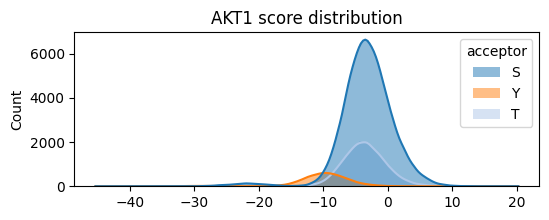

In [23]:
plot_hist(df,'AKT1')

In [24]:
for k,r in tqdm(cddm_info.iterrows(),total=len(cddm_info)):
    sty_thr=r[thr_cols].rename(index={'S_thr':'S','T_thr':'T','Y_thr':'Y'})[lambda x: x!=0].to_dict()
    plot_hist(df,k,sty_thr=sty_thr)
    save_show(f'fig/cddm/{k}/path/hist.svg',show_only=False)
plt.close('all')

100%|█████████████████████████████████████████████████████████| 328/328 [03:14<00:00,  1.68it/s]


## Plot reactome pathway

In [5]:
info = Data.get_kinase_info()

In [6]:
info = info[info.pseudo=='0']

In [7]:
info.uniprot.duplicated().sum()

np.int64(0)

In [8]:
kinase_map = info.set_index('kinase')['uniprot']

In [9]:
def get_path(series):
    out = get_reactome(series['genes'],p_type='p')
    kinase=series.name.split('_')[0] # for those with _TRY, need to remove that
    uniprot = kinase_map[kinase]
    out = add_reactome_ref(out,uniprot)
    exclude=['GTPase','SUMO']
    out = out[~out.name.str.contains('|'.join(exclude))]
    return out

In [10]:
show_only=False

In [37]:
cddm_info.index.get_loc('YSK1')

96

In [14]:
len(cddm_info)

328

In [13]:
for i,(k,r) in enumerate(cddm_info.iterrows()):
    print(i,':',k)
    save_dir = f'fig/cddm/{k}/path'
    
    path_df = get_path(r)
    path_df.to_parquet(f'{save_dir}/path.parquet')

    plot_path(path_df,p_type='p',ref_col='ref_path',top_n=15,max_label_length=55)
    plt.title('Reactome pathways of substrates based on scores')
    save_show(f'{save_dir}/path.svg',show_only=show_only)

    if path_df.ref_path.sum()!=0:
        accuracy = get_overlap(path_df, ref_col='ref_path',plot=True,p_type='p',figsize=(5,3))
        plt.title(f'Distribution of –log₁₀(p) for reference pathways')
        save_show(f'{save_dir}/overlap.svg',show_only=show_only)

    if path_df.ref_path_lowest.sum()!=0:
        accuracy_lo = get_overlap(path_df, ref_col='ref_path_lowest',plot=True,p_type='p',figsize=(5,3))
        plt.title(f'Distribution of –log₁₀(p) for reference pathways \n(lowest-level)')
        save_show(f'{save_dir}/overlap_lo.svg',show_only=show_only)
    plt.close('all')
    # break
    
    # ✅ polite delay to avoid API throttling
    delay = random.uniform(1.5, 4)
    print(f"Sleeping {delay:.2f}s before next kinase...")
    time.sleep(delay)

0 : SRC
Running pathway anlysis
Done
Sleeping 3.98s before next kinase...
1 : EPHA3
Running pathway anlysis
Done
Sleeping 1.77s before next kinase...
2 : FES
Running pathway anlysis
Done
Sleeping 2.18s before next kinase...
3 : NTRK3
Running pathway anlysis
Done
Sleeping 3.29s before next kinase...
4 : ALK
Running pathway anlysis
Done
Sleeping 3.96s before next kinase...
5 : ABL1
Running pathway anlysis
Done
Sleeping 2.73s before next kinase...
6 : FLT3
Running pathway anlysis
Done
Sleeping 2.95s before next kinase...
7 : EPHA8
Running pathway anlysis
Done
Sleeping 1.94s before next kinase...
8 : EPHB2
Running pathway anlysis
Done
Sleeping 3.69s before next kinase...
9 : EPHB1
Running pathway anlysis
Done
Sleeping 2.95s before next kinase...
10 : RET
Running pathway anlysis
Done
Sleeping 2.36s before next kinase...
11 : FYN
Running pathway anlysis
Done
Sleeping 3.14s before next kinase...
12 : FER
Running pathway anlysis
Done
Sleeping 1.84s before next kinase...
13 : INSR
Running pathw

## Get accuracy for overlap pathways

In [16]:
acc_dict, num_dict = {}, {}
acc_lo_dict, num_lo_dict = {}, {}

for k,r in tqdm(cddm_info.iterrows(),total=len(cddm_info)):
    save_dir = f'fig/cddm/{k}/path'
    
    path_df=pd.read_parquet(f'{save_dir}/path.parquet')

    if path_df.ref_path.sum()!=0:
        accuracy = get_overlap(path_df, ref_col='ref_path',plot=False,p_type='p')
        acc_dict[k] = accuracy
        num_dict[k] =path_df.ref_path.sum()

    if path_df.ref_path_lowest.sum()!=0:
        accuracy_lo = get_overlap(path_df, ref_col='ref_path_lowest',plot=False,p_type='p')
        acc_lo_dict[k] = accuracy_lo
        num_lo_dict[k] = path_df.ref_path_lowest.sum()
    # break

100%|███████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 214.60it/s]


In [17]:
cddm_info['accuracy'] = acc_dict
cddm_info['path_num'] = num_dict
cddm_info['accuracy_lowest'] = acc_lo_dict
cddm_info['path_lowest_num'] = num_lo_dict

In [18]:
cddm_info['path_num'] = cddm_info['path_num'].fillna(0).astype(int)
cddm_info['path_lowest_num'] = cddm_info['path_lowest_num'].fillna(0).astype(int)

In [20]:
cddm_info.to_parquet('raw/cddm_path_info.parquet')

## Analysis

In [7]:
def plot_path_hist(df,
              colname,
              **kwargs,
              ):
    
    "Plot histogram of a column (kinase). "
    
    plt.figure(figsize=(6,2))

    hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True,
              }
    
    sns.histplot(data=df,x=colname,**kwargs, **hist_params)
    
    plt.xlabel('')
    plt.title(f'Accuracy score distribution')

In [40]:
q75, q50 = cddm_info.path_num[lambda x: x!=0].quantile([0.75,0.5])
q75, q50

(37.5, 14.0)

In [41]:
def categorize_path_num(x):
    if x >= q75: return f'well known (≥{q75:.0f})'
    elif x <= q50: return f'less known (≤{q50:.0f})'
    else: return f'middle ({q50:.0f}–{q75:.0f})'

In [42]:
cddm_info['category'] = cddm_info['path_num'].apply(categorize_path_num)

In [43]:
cddm_info['category'].value_counts()

category
less known (≤14)    188
well known (≥38)     62
middle (14–38)       61
Name: count, dtype: int64

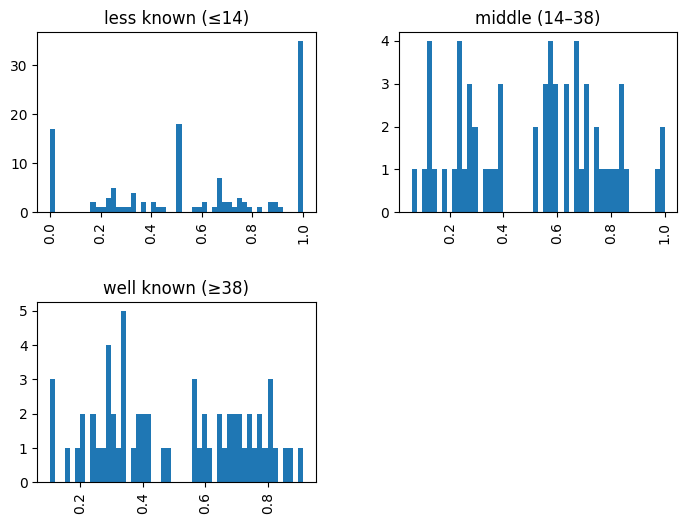

In [44]:
cddm_info.hist(column='accuracy', by='category', bins=50, figsize=(8,6));

In [45]:
cddm_info[cddm_info.path_num>q50].accuracy.mean()

np.float64(0.5057438274707422)

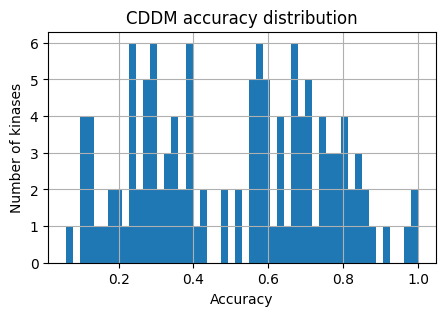

In [46]:
cddm_info[cddm_info.path_num>q50].accuracy.hist(bins=50,figsize=(5,3))
plt.xlabel('Accuracy')
plt.ylabel('Number of kinases')
plt.title('CDDM accuracy distribution');

### Lowest

In [47]:
cddm_info.path_lowest_num[lambda x: x!=0].quantile([0.75])

0.75    11.5
Name: path_lowest_num, dtype: float64

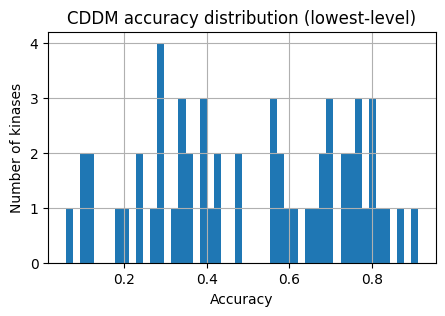

In [48]:
cddm_info[cddm_info.path_lowest_num>12].accuracy.hist(bins=50,figsize=(5,3))
plt.xlabel('Accuracy')
plt.ylabel('Number of kinases')
plt.title('CDDM accuracy distribution (lowest-level)');

## Compare with PSPA

In [27]:
pspa_info=pd.read_parquet('raw/pspa_path_info.parquet')
cddm_info = pd.read_parquet('raw/cddm_path_info.parquet')

In [28]:
idx = list(set(pspa_info.index)&set(cddm_info.index))

In [33]:
# make sure total path number are same among the two
(cddm_info.loc[idx].path_num==pspa_info.loc[idx].path_num).value_counts()

path_num
True    311
Name: count, dtype: int64

In [49]:
pspa_info = pspa_info.loc[idx][pspa_info.path_num>14]
cddm_info = cddm_info.loc[idx][cddm_info.path_num>14]

In [51]:
pspa_info['cddm_accuracy'] = cddm_info.accuracy

In [52]:
pspa_info['cddm_accuracy'].isna().sum()

np.int64(0)

In [53]:
data = pspa_info[['accuracy','cddm_accuracy']].melt()

In [54]:
data.head()

,variable,value
0,accuracy,0.580645
1,accuracy,0.200000
2,accuracy,0.345679
3,accuracy,0.129032
4,accuracy,0.500000


In [55]:
data = data.replace({
    'accuracy': 'PSPA',
    'cddm_accuracy': 'CDDM'
})

In [56]:
def plot_violin(
    data, 
    value='value',
    group='variable', 
    ylabel=None, 
    dots=True, 
    figsize=(5,3),
    **kwargs
):
    "Plot violin plots (with optional strip dots) for long-form data."

    plt.figure(figsize=figsize)

    ax=sns.violinplot(
        data=data, x=group, y=value,
        inner='box', linewidth=1,
        cut=0,         # prevents tails extending beyond data range
        bw_adjust=0.7,  # the smaller, the shape have more curves that fit to the data
        hue=group,**kwargs
    )

    if dots:
        sns.stripplot(
            data=data, x=group, y=value,
            color='k', size=2, jitter=0.1, alpha=0.6
        )

    plt.xlabel('')
    if ylabel is not None: plt.ylabel(ylabel)
    plt.tight_layout()
    return ax

In [57]:
from statannotations.Annotator import Annotator
import itertools

In [58]:
def add_stats(ax,data,value='value',group='variable',pairs=None,test='t-test_ind',loc='inside',text_format='star',**kwargs):
    group_items = data[group].unique()
    if pairs is None: pairs = list(itertools.combinations(group_items, 2))
    annotator = Annotator(ax, pairs, data=data, x=group, y=value)
    annotator.configure(test=test, text_format=text_format, loc=loc,verbose=False,**kwargs)
    annotator.apply_and_annotate()

In [ ]:
wide = pspa_info[['accuracy','cddm_accuracy']]

wide.columns=['PSPA','CDDM']

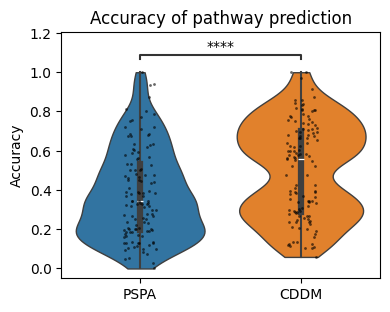

In [60]:
ax = plot_violin(data,ylabel='Accuracy',figsize=(4,3))
plt.title('Accuracy of pathway prediction')
add_stats(ax,data,test='t-test_paired')
save_svg('fig/pathway_compare.svg')

In [61]:
(pspa_info['cddm_accuracy']-pspa_info['accuracy']).sort_values(ascending=False)

kinase
MEKK1     0.789474
ABL1      0.755102
PKCG      0.629630
TBK1      0.617021
CAMKK1    0.600000
            ...   
IRAK4    -0.366667
FGFR4    -0.393939
NTRK1    -0.437500
NTRK2    -0.600000
PDGFRB   -0.733333
Length: 123, dtype: float64